In [1]:
#Installing the imbalanced learn module for access to a variety of over-sampling methods

#!pip install imbalanced-learn
#!pip install numpy==1.21
#!pip install lxml

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('Data/clean_gss.csv')
df.head()

,Unnamed: 0,LONELY2,SATJOB,MOREDAYS,WRKHOME,HLTHPHYS,HLTHMNTL,CONWKDAY,PARTLSC,AGE,MARITAL,EDUC,is_si,marital_cat,MOREWEEKS,Age Group
0,3,2.0,1.0,2.0,1.0,1.0,1.0,4.0,3.0,63.0,1.0,4,0,1,1,4
1,6,3.0,1.0,1.0,1.0,3.0,2.0,3.0,2.0,59.0,3.0,3,1,0,1,3
2,7,1.0,1.0,24.0,1.0,2.0,3.0,4.0,5.0,43.0,5.0,2,0,0,4,2
3,9,3.0,2.0,3.0,1.0,2.0,3.0,4.0,1.0,55.0,1.0,2,1,1,1,3
4,11,3.0,2.0,6.0,1.0,3.0,3.0,2.0,1.0,34.0,4.0,3,1,0,1,2


In [3]:
# Getting rid of redundant columns from initial dataframe

gss= df[['SATJOB','WRKHOME', 'HLTHPHYS', 'HLTHMNTL', 'CONWKDAY', 'PARTLSC', 'EDUC', 'is_si', 'MOREWEEKS', 'Age Group']]
gss.head()

,SATJOB,WRKHOME,HLTHPHYS,HLTHMNTL,CONWKDAY,PARTLSC,EDUC,is_si,MOREWEEKS,Age Group
0,1.0,1.0,1.0,1.0,4.0,3.0,4,0,1,4
1,1.0,1.0,3.0,2.0,3.0,2.0,3,1,1,3
2,1.0,1.0,2.0,3.0,4.0,5.0,2,0,4,2
3,2.0,1.0,2.0,3.0,4.0,1.0,2,1,1,3
4,2.0,1.0,3.0,3.0,2.0,1.0,3,1,1,2


<AxesSubplot:>

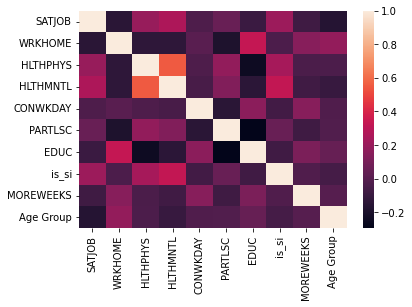

In [4]:
# Checking for multicollinearity- looks good

corr = gss.corr()
sns.heatmap(corr)

In [6]:
# Starting to split data to prepare for modeling

X= gss[['SATJOB','WRKHOME', 'HLTHPHYS', 'HLTHMNTL', 'CONWKDAY', 'PARTLSC','EDUC', 'MOREWEEKS', 'Age Group' ]]
y= gss['is_si']

In [7]:
from imblearn.over_sampling import SMOTEN
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.3, random_state= 42)

# Resampling only the training data
os= SMOTEN(random_state= 42)
os_X, os_y= os.fit_resample(X_train, y_train)

In [8]:
# Verifying we now have 50/50 isolated to non-isolated for training data

os_y.value_counts()

1    364
0    364
Name: is_si, dtype: int64

In [9]:
# SATJOB, HLTHPHYS, PARTLSC, MARITAL_2, MARITAL_5 all have p-value above 0.05 lacking statistical significance

import statsmodels.api as sm

sm_logit = sm.Logit(os_y, os_X)
result = sm_logit.fit()
print(result.summary())

#save results for later
summary_df5 = pd.read_html(result.summary().tables[1].as_html(), header=0, index_col=0)[0]

Optimization terminated successfully.
         Current function value: 0.581913
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                  is_si   No. Observations:                  728
Model:                          Logit   Df Residuals:                      719
Method:                           MLE   Df Model:                            8
Date:                Tue, 11 Apr 2023   Pseudo R-squ.:                  0.1605
Time:                        12:11:45   Log-Likelihood:                -423.63
converged:                       True   LL-Null:                       -504.61
Covariance Type:            nonrobust   LLR p-value:                 6.232e-31
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
SATJOB         0.2740      0.109      2.509      0.012       0.060       0.488
WRKHOME       -0.2468      0.

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

sk_logit = LogisticRegression()
sk_logit.fit(os_X, os_y)
y_pred = sk_logit.predict(X_test)
print('Accuracy on test set:{:.2f}'.format(sk_logit.score(X_test, y_test)))

Accuracy on test set:0.67


In [11]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.70      0.76       156
           1       0.39      0.59      0.47        51

    accuracy                           0.67       207
   macro avg       0.61      0.64      0.62       207
weighted avg       0.73      0.67      0.69       207



In [13]:
for age_group in gss['Age Group'].unique():
    age = gss.loc[gss['Age Group']== age_group]
    
    # Starting to split data to prepare for modeling
    
    #'Marital_2.0','Marital_3.0', 'Marital_4.0', 'Marital_5.0'
    X= age[['SATJOB','WRKHOME', 'HLTHPHYS', 'HLTHMNTL', 'CONWKDAY', 'PARTLSC','EDUC', 'MOREWEEKS']]
    y= age['is_si']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.3, random_state= 42)

    # Resampling only the training data
    os= SMOTEN(random_state= 42)
    os_X, os_y= os.fit_resample(X_train, y_train)

    sm_logit = sm.Logit(os_y, os_X)
    result = sm_logit.fit()
    print("Age Group:{:.2f}".format(age_group))
    print(result.summary())

    sk_logit = LogisticRegression()
    sk_logit.fit(os_X, os_y)
    y_pred = sk_logit.predict(X_test)
    print('Accuracy on test set:{:.2f}'.format(sk_logit.score(X_test, y_test)))

#Saving summary data to a dataframe for plots
    if age_group==1.0:
        summary_df1 = pd.read_html(result.summary().tables[1].as_html(), header=0, index_col=0)[0]

    if age_group==2.0:
        summary_df2 = pd.read_html(result.summary().tables[1].as_html(), header=0, index_col=0)[0]

    if age_group==3.0:
        summary_df3 = pd.read_html(result.summary().tables[1].as_html(), header=0, index_col=0)[0]

    if age_group==4.0:
        summary_df4 = pd.read_html(result.summary().tables[1].as_html(), header=0, index_col=0)[0]


    

Optimization terminated successfully.
         Current function value: 0.457409
         Iterations 6
Age Group:4.00
                           Logit Regression Results                           
Dep. Variable:                  is_si   No. Observations:                  104
Model:                          Logit   Df Residuals:                       96
Method:                           MLE   Df Model:                            7
Date:                Tue, 11 Apr 2023   Pseudo R-squ.:                  0.3401
Time:                        12:13:30   Log-Likelihood:                -47.571
converged:                       True   LL-Null:                       -72.087
Covariance Type:            nonrobust   LLR p-value:                 2.235e-08
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
SATJOB        -0.7144      0.456     -1.565      0.118      -1.609       0.180
WRKHOME       

In [14]:
#Create a new list to hold data that will be used for plotting
summary_plot = []

#Add a new column in each summary dataframe that indicates the Age group of the dataframe
summary_df1['Age Group'] = 1
summary_df2['Age Group'] = 2
summary_df3['Age Group'] = 3
summary_df4['Age Group'] = 4
summary_df5['Age Group'] = 5

for table in [summary_df1,summary_df2,summary_df3,summary_df4, summary_df5]:
    #Track the index
    index= 0
    for row in table['P>|z|']:
        
        if row <= .05:
            summary_plot.append(table.iloc[index])
        index+=1
       

In [15]:
summary_df = pd.DataFrame()
for each_df in summary_plot:
    summary_df = pd.concat([summary_df, each_df], axis=1 )
summary_df = summary_df.transpose()
summary_df['Age Group'] = summary_df['Age Group'].astype('int32')

In [16]:
summary_df.rename(index={'HLTHPHYS': 'Physical Health',
                         'CONWKDAY':'# of Weekday Interactions', 
                         'HLTHMNTL':'Mental Health',
                         'MOREWEEKS':'Extra Hours Worked',
                         'PARTLSC':'Participation in groups',
                         'SATJOB':'Job Satisfaction',
                         'WRKHOME':'Work from Home'},inplace=True)
list(summary_df.index)


['Participation in groups',
 'Extra Hours Worked',
 'Work from Home',
 '# of Weekday Interactions',
 'Job Satisfaction',
 'Work from Home',
 'Mental Health',
 'Participation in groups',
 'Mental Health',
 '# of Weekday Interactions',
 'Job Satisfaction',
 'Work from Home',
 'Mental Health',
 '# of Weekday Interactions']

In [17]:
summary_df

,coef,std err,z,P>|z|,[0.025,0.975],Age Group
Participation in groups,-0.2932,0.112,-2.606,0.009,-0.514,-0.073,1
Extra Hours Worked,-0.4956,0.210,-2.360,0.018,-0.907,-0.084,1
Work from Home,-0.4384,0.112,-3.926,0.000,-0.657,-0.220,2
# of Weekday Interactions,-0.3501,0.103,-3.413,0.001,-0.551,-0.149,2
Job Satisfaction,-1.2307,0.321,-3.833,0.000,-1.860,-0.601,3
Work from Home,-0.6149,0.171,-3.598,0.000,-0.950,-0.280,3
Mental Health,1.4716,0.308,4.784,0.000,0.869,2.074,3
Participation in groups,0.2765,0.126,2.202,0.028,0.030,0.523,3
Mental Health,0.9437,0.473,1.997,0.046,0.017,1.870,4
# of Weekday Interactions,-0.8259,0.225,-3.668,0.000,-1.267,-0.385,4


In [18]:
# plotting some radar plots?
# ne
# much courtesy of https://www.python-graph-gallery.com/392-use-faceting-for-radar-chart
# Libraries
#import matplotlib.pyplot as plt
#import pandas as pd
from math import pi
#from matplotlib import colormaps

# categories are the var names
# only doing one group. Group A
# values is every value under A plus a repeat of the first (so it closes)
 
# ------- PART 1: Define a function that do a plot for one line of the dataset!
 
def make_spider( row, title, color, df):
    # number of variable
    categories=list(df.index)
    N = len(categories)
    # What will be the angle of each axis in the plot? (we divide the plot / number of variable)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]
    
    # Initialise the spider plot
    ax = plt.subplot(3,2,row, polar=True, )
    # If you want the first axis to be on top:
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)
    # Draw one axe per variable + add labels labels yet
    plt.xticks(angles[:-1], categories, color='black', size=15)
    # Draw ylabels
    ax.set_rlabel_position(0)
    plt.yticks([0,1,2,3,4,5], ["0","1","2",'3','4','5'], color="black", size=10)
    plt.ylim(0,5)
    # Ind1
    #values=df.loc[row].drop('group').values.flatten().tolist()
    # values=df.iloc[:,row-1].tolist()
    values = abs(df['coef']).tolist()
    values += values[:1]
    print(f'{values} {angles}')
    ax.plot(angles, values, color=color, linewidth=2, linestyle='solid')
    ax.fill(angles, values, color=color, alpha=0.4)
    # Add a title
    plt.title(title, size=18, color=color, y=1.0,x=0.01)
    
# ------- PART 2: Apply the function to all individuals
# initialize the figure
my_dpi=96
plt.figure(figsize=(1500/my_dpi, 1300/my_dpi), dpi=my_dpi)
 
# Create a color palette:
#my_palette = colormaps["Set2"]
 
# # Loop to plot
# for row in range(0, len(df.index)):
#     make_spider( row=row, title='group '+df['group'][row], color=my_palette(row))
    
for row in summary_df['Age Group'].unique():
    title = ''
    if row == 1:
        title = '18-29 \n Accuracy: 64%\n\n'
        #make_spider( row=row, title=f'Age Group: {title}', color=my_palette(row), df = summary_df.loc[summary_df['Age Group'] == row])
        #break
    if row == 2:
        title = '30-44 \n Accuracy: 72%\n\n'
        #make_spider( row=row, title=f'Age Group: {title}', color=my_palette(row), df = summary_df.loc[summary_df['Age Group'] == row])
        #break
    if row == 3:
        title = '45-59 \n Accuracy: 60%\n\n'
        make_spider( row=row, title=f'Age Group: {title}', color=my_palette(row), df = summary_df.loc[summary_df['Age Group'] == row])
        break
    if row == 4:
        title = '60+ \n Accuracy: 80%\n\n'
        #make_spider( row=row, title=f'Age Group: {title}', color=my_palette(row), df = summary_df.loc[summary_df['Age Group'] == row])
        #break
    if row == 5:
        title = 'All\nAccuracy: 72%\n\n'
        #make_spider( row=row, title=f'Age Group: {title}', color=my_palette(row), df = summary_df.loc[summary_df['Age Group'] == row])
        #break
    #make_spider( row=row, title=f'Age Group: {title}', color=my_palette(row), df = summary_df.loc[summary_df['Age Group'] == row])
    


NameError: name 'my_palette' is not defined

<Figure size 1500x1300 with 0 Axes>

In [19]:
plot_data = pd.DataFrame(summary_plot)
plot_data['Variable']= plot_data.index

In [20]:
clean_plot_data = pd.DataFrame(pd.crosstab(plot_data['Age Group'],plot_data['Variable'],values=plot_data['coef'],aggfunc=sum))
clean_plot_data

Variable,CONWKDAY,HLTHMNTL,MOREWEEKS,PARTLSC,SATJOB,WRKHOME
Age Group,,,,,,
1.0,NaN,NaN,-0.4956,-0.2932,NaN,NaN
2.0,-0.3501,NaN,NaN,NaN,NaN,-0.4384
3.0,NaN,1.4716,NaN,0.2765,-1.2307,-0.6149
4.0,-0.8259,0.9437,NaN,NaN,NaN,NaN
5.0,-0.2271,0.6536,NaN,NaN,0.2740,-0.2468


ValueError: The number of FixedLocator locations (6), usually from a call to set_ticks, does not match the number of ticklabels (7).

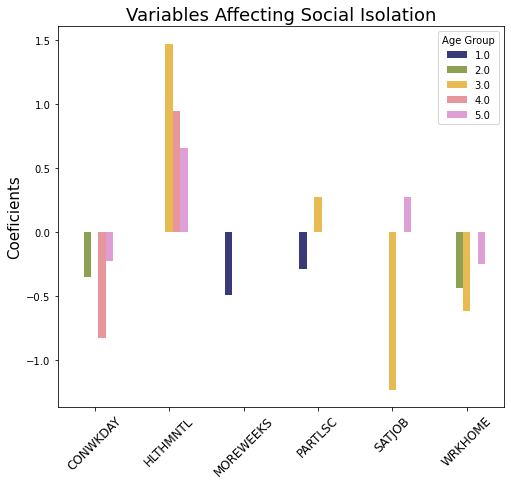

In [22]:
#plt.figure(figsize=(10,10))
ax = clean_plot_data.transpose().plot.bar(figsize=(8,7),rot=0,cmap='tab20b')

plt.title('Variables Affecting Social Isolation', fontsize=18)
plt.ylabel('Coeficients',fontsize=15)
plt.xlabel('',fontsize=15)
ax.tick_params(axis='y',labelsize=10)
ax.tick_params(axis='x', labelsize=12,rotation=45)
ax.set_xticklabels(['# of Weekday Interactions', 'Mental Health', 'Physical Health','moreweeks', 'Participation in groups','Job Satisfaction','Work from Home'])
plt.setp(ax.xaxis.get_majorticklabels(), ha="right" )
ax.legend(labels=['18-29', '30-44','45-59','60+'])

ValueError: The number of FixedLocator locations (6), usually from a call to set_ticks, does not match the number of ticklabels (7).

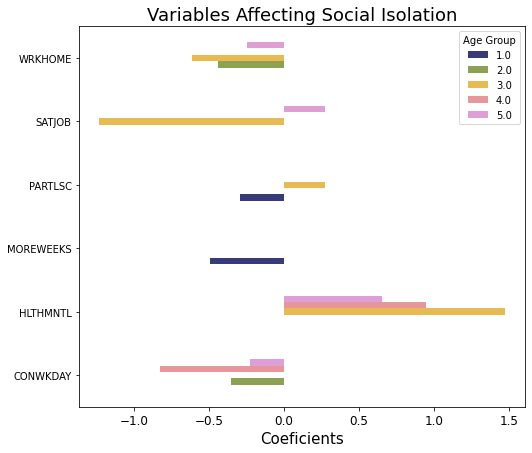

In [24]:
#plt.figure(figsize=(10,10))
ax = clean_plot_data.transpose().plot.barh(figsize=(8,7),rot=0,cmap='tab20b')

plt.title('Variables Affecting Social Isolation', fontsize=18)
plt.xlabel('Coeficients',fontsize=15)
plt.ylabel('',fontsize=15)
ax.tick_params(axis='x',labelsize=12)
ax.tick_params(axis='y', labelsize=10)
ax.set_yticklabels(['# of Weekday Interactions', 'Mental Health', 'Physical Health','Job Overtime','Participation in Groups','Job Satisfaction','Work From Home'])
plt.setp(ax.yaxis.get_majorticklabels(), ha="right" )
ax.legend(labels=['18-29', '30-44','45-59','60+'])